### Dataframe de ejemplo para el areaplot y snapshot

In [1]:
import numpy as np
import pandas as pd

# ==============================================
# 1. DATOS 
# ==============================================
n = 12
fechas = pd.date_range(start="2023-01-01", periods=n, freq="MS")
comisiones = np.random.rand(n) * 0.4
fiscalias = np.random.rand(n) * 0.4
portal = np.random.rand(n) * 0.2


# Crear el DataFrame
data = pd.DataFrame({
    'fechas': fechas,
    'comisiones': comisiones,
    'fiscalias': fiscalias,
    'portal': portal
})

data

,fechas,comisiones,fiscalias,portal
0,2023-01-01,0.279076,0.205411,0.040469
1,2023-02-01,0.042854,0.059204,0.128528
2,2023-03-01,0.319384,0.034248,0.072349
3,2023-04-01,0.371538,0.003006,0.109026
4,2023-05-01,0.321829,0.181851,0.042867
5,2023-06-01,0.325514,0.297880,0.146873
6,2023-07-01,0.361760,0.198982,0.022230
7,2023-08-01,0.299010,0.003908,0.197859
8,2023-09-01,0.253065,0.090131,0.033916
9,2023-10-01,0.303069,0.191556,0.195863


### **Código a copiar para el areaplot y snapshot:**

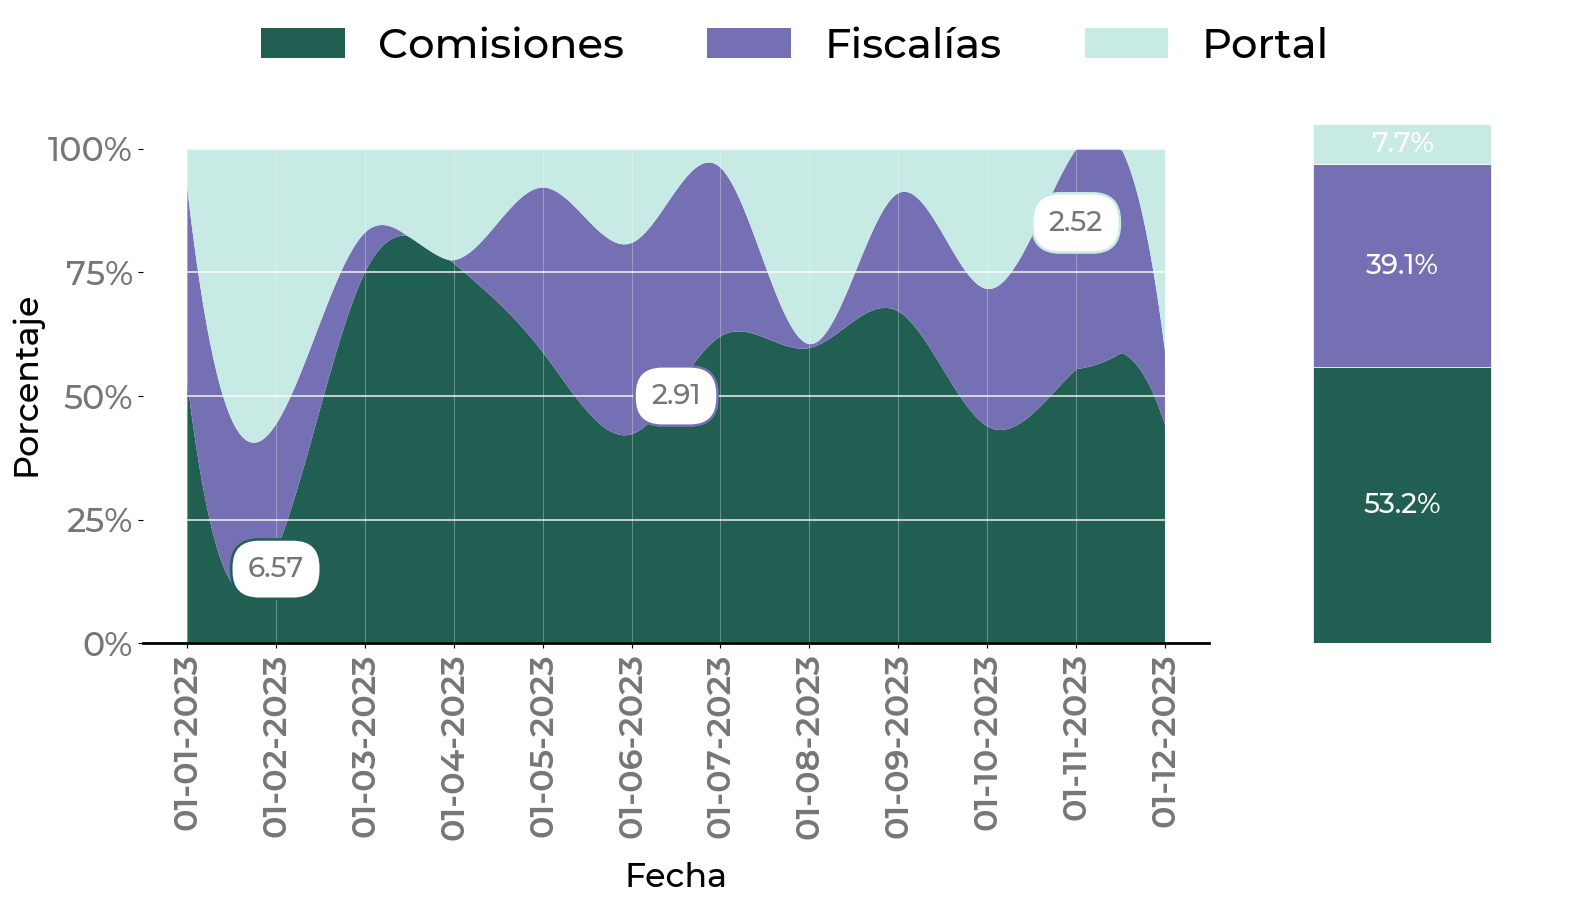

In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.interpolate import make_interp_spline

def formato_fechas(fechas):
    fechas = pd.to_datetime(fechas)
    # Si todos los años son diferentes, mostrar solo el año
    if len(set(f.year for f in fechas)) == len(fechas):
        return [str(f.year) for f in fechas]
    else:
        return [f.strftime("%d-%m-%Y") for f in fechas]

def snapshot(data, 
             nombre=None, 
             font='Montserrat',
             columna_fechas='fechas',
             colores=None,
             etiquetas=None,
             suavizar=True,
             num_puntos=300
             ):
    """
    Genera un gráfico de área apilada con los datos proporcionados en un DataFrame.

    Parámetros:
    - data: DataFrame que contiene una columna de fechas y varias columnas de datos.
    - columna_fechas: nombre de la columna que contiene las fechas.
    - colores: lista de colores para las áreas (opcional).
    - etiquetas: lista de etiquetas para las áreas (opcional).
    """
    font_config = {
        'family': font,
        'nombre_eje_x': {'size': 24, 'weight': 'medium', 'color': '#000000'},
        'nombre_eje_y': {'size': 24, 'weight': 'medium', 'color': '#000000'},
        'variable_x': {'size': 24, 'weight': 'semibold', 'color': '#767676'},
        'variable_y': {'size': 24, 'weight': 'medium', 'color': '#767676'},
        'capsula_valor': {'size': 20, 'weight': 'medium', 'color': '#767676'},
        'porcentaje': {'size': 20, 'weight': 'medium', 'color': 'white'},
        'leyenda': {'size': 30, 'weight': 'medium', 'color': '#767676'}
    }

    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['font.family'] = font_config['family']

    font_dirs = [Path("../0_fonts")]
    if Path(font_dirs[0]).exists():
        font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
        for font_file in font_files:
            font_manager.fontManager.addfont(font_file)

    nombre_df = nombre or "snapshot"

    # Detectar columnas de datos
    columnas = [col for col in data.columns if col != columna_fechas]
    fechas = data[columna_fechas]
    valores = [data[col] for col in columnas]

    # Normalizar evitando división por cero
    total = np.sum(valores, axis=0)
    total[total == 0] = 1
    valores_norm = [v / total for v in valores]

    n = len(fechas)
    x = np.arange(n) + 0.5

    fig_sub = plt.figure(figsize=(16, 8))
    gs = fig_sub.add_gridspec(1, 2, width_ratios=[3, 1], height_ratios=[1])

    # Colores y etiquetas dinámicos
    if not colores:
        cmap = plt.get_cmap('tab20')
        colores = [cmap(i) for i in range(len(columnas))]
    if not etiquetas:
        etiquetas = columnas

    # Gráfico de áreas
    ax1 = fig_sub.add_subplot(gs[0])
    if suavizar:
        x_suave = np.linspace(x.min(), x.max(), num_puntos)
        # Suavizar cada serie
        valores_suave_raw = [make_interp_spline(x, v)(x_suave) for v in valores_norm]
        # Forzar límites a los valores suavizados: mínimo 0, máximo 100
        valores_suave_raw = [np.clip(v, 0, 100) for v in valores_suave_raw]
        # Normalizar para que sumen 1 en cada punto
        suma_suave = np.sum(valores_suave_raw, axis=0)
        suma_suave[suma_suave == 0] = 1  # evitar división por cero
        valores_suave = [v / suma_suave for v in valores_suave_raw]
        ax1.stackplot(x_suave, *valores_suave, labels=etiquetas, colors=colores)
    else:
        ax1.stackplot(x, *valores_norm, labels=etiquetas, colors=colores)

    # Eje X
    ax1.set_xticks(x)
    ax1.set_xticklabels(
        formato_fechas(fechas), rotation=90,
        fontdict={
            'fontsize': font_config['variable_x']['size'],
            'fontweight': font_config['variable_x']['weight'],
            'color': font_config['variable_x']['color'],
            'family': font_config['family']
        }
    )
    ax1.set_xlim(x[0] - 0.5, x[-1] + 0.5)

    # Eje Y
    ax1.set_yticks(np.linspace(0, 1, 5))
    ax1.set_yticklabels(
        ['0%', '25%', '50%', '75%', '100%'],
        fontdict={
            'fontsize': font_config['variable_y']['size'],
            'fontweight': font_config['variable_y']['weight'],
            'color': font_config['variable_y']['color'],
            'family': font_config['family']
        }
    )

    ax1.set_xlabel(
        "Fecha",
        fontsize=font_config['nombre_eje_x']['size'],
        fontweight=font_config['nombre_eje_x']['weight'],
        color=font_config['nombre_eje_x']['color'],
        family=font_config['family'],
        labelpad=16  # <-- Agrega separación aquí
    )
    ax1.set_ylabel(
        "Porcentaje",
        fontsize=font_config['nombre_eje_y']['size'],
        fontweight=font_config['nombre_eje_y']['weight'],
        color=font_config['nombre_eje_y']['color'],
        family=font_config['family']
    )

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.grid(axis='y', linestyle='-', color='white', alpha=0.8, linewidth=1.25)
    ax1.grid(axis='x', linestyle='-', color='white', alpha=0.3, linewidth=0.75)

    # Etiquetas de totales
    x_coords = np.linspace(x[1], x[-2], len(columnas))
    y_coords = np.linspace(0.15, 0.85, len(columnas))
    totales = [np.sum(v) for v in valores_norm]

    for x_c, y_c, total, color_borde in zip(x_coords, y_coords, totales, colores):
        ax1.text(
            x_c, y_c, f"{total:.2f}",
            ha='center', va='center',
            fontsize=font_config['capsula_valor']['size'],
            color=font_config['capsula_valor']['color'],
            fontweight=font_config['capsula_valor']['weight'],
            family=font_config['family'],
            bbox=dict(boxstyle="round,pad=0.6,rounding_size=1",
                      facecolor='white', edgecolor=color_borde, linewidth=1.8)
        )

    # Snapshot
    ax2 = fig_sub.add_subplot(gs[1])
    primeros = np.array([v[0] for v in valores_norm])
    totales_norm = primeros / primeros.sum() if primeros.sum() != 0 else np.zeros_like(primeros)
    bar_width = 0.5
    bottom = 0
    for valor, color in zip(totales_norm, colores):
        ax2.bar(0, valor, width=bar_width, bottom=bottom,
                color=color, edgecolor='white', linewidth=0.5)
        ax2.text(
            0, bottom + valor/2, f"{valor*100:.1f}%",
            ha='center', va='center',
            color=font_config['porcentaje']['color'],
            fontweight=font_config['porcentaje']['weight'],
            fontsize=font_config['porcentaje']['size'],
            family=font_config['family']
        )
        bottom += valor

    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylim(0, 1)
    ax2.set_xticks([])
    ax2.set_yticks([])
    for spine in ax2.spines.values():
        spine.set_visible(False)
    ax2.tick_params(bottom=False, labelbottom=False)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    leyenda_font = font_manager.FontProperties(
        family=font_config['family'],
        size=font_config['leyenda']['size'],
        weight=font_config['leyenda']['weight']
    )

    fig_sub.legend(
        etiquetas,
        loc='upper center',
        ncol=len(columnas),
        frameon=False,
        fontsize=font_config['leyenda']['size'],
        prop=leyenda_font,
        bbox_to_anchor=(0.5, 1.15)
    )

    plt.tight_layout()
    plt.savefig(f"{nombre_df}.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.savefig(f"{nombre_df}.png", format='png', bbox_inches='tight', dpi=300)
    plt.show()

snapshot(data, 
         colores=['#215F53', '#7570B3', '#C7EAE5'],
         etiquetas=['Comisiones', 'Fiscalías', 'Portal'],
         suavizar=True
         )